In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import collections
import os
import random
from io import BytesIO
from uuid import uuid4

import diffusers
import einops
import PIL
import requests
import sh
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF
from attention_augmentation import collect_attention, replace_attention
from controlnet_aux import HEDdetector
from diffusers import (ControlNetModel, DDIMInverseScheduler, DDIMScheduler,
                       EulerAncestralDiscreteScheduler,
                       StableDiffusionControlNetPipeline,
                       StableDiffusionInpaintPipeline, StableDiffusionPipeline,
                       UniPCMultistepScheduler)
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint import *
from diffusers.utils.torch_utils import randn_tensor
from einops import rearrange, repeat
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import sh

In [14]:
dt = torch.bfloat16

In [15]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_softedge", torch_dtype=dt).cuda()
pipe = StableDiffusionControlNetPipeline.from_pretrained("Lykon/DreamShaper", safety_checker=None, controlnet=controlnet, variant="bf16", torch_dtype=dt).to('cuda')
pipe.safety_checker = None

[p.requires_grad_(False) for p in [pipe.vae, pipe.unet, pipe.text_encoder, controlnet]];

/home/robert/miniconda3/envs/ml23c/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py:1223: FutureWarning: You are trying to load the model files of the `variant=bf16`, but no such modeling files are available.The default model files: {'safety_checker/pytorch_model.bin', 'text_encoder/pytorch_model.bin', 'vae/diffusion_pytorch_model.bin', 'unet/diffusion_pytorch_model.bin'} will be loaded instead. Make sure to not load from `variant=bf16`if such variant modeling files are not available. Doing so will lead to an error in v0.22.0 as defaulting to non-variantmodeling files is deprecated.
  deprecate("no variant default", "0.22.0", deprecation_message, standard_warn=False)
text_encoder/model.safetensors not found
/home/robert/miniconda3/envs/ml23c/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor inste

In [16]:
ts = 20
ddim_inv = DDIMInverseScheduler.from_config(pipe.scheduler.config)
ddim_fwd = DDIMScheduler.from_config(pipe.scheduler.config)
ddim_inv.set_timesteps(ts)
ddim_fwd.set_timesteps(ts)
# pipe.scheduler = EulerAncestralDiscreteScheduler().from_config(pipe.scheduler.config) #ddim_fwd
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(ts)

The config attributes {'dynamic_thresholding_ratio': 0.995, 'rescale_betas_zero_snr': False, 'sample_max_value': 1.0, 'thresholding': False} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [24]:
frame_shape = (512, 512)
sh.mkdir('-p', 'frames')
sh.ffmpeg("-i", "original.mp4", "-vf", f"crop=512:512:(in_w-512)/2:(in_h-512)/2", "-r", "15", f"frames/%04d.png")
frames = [Image.open(x).resize(frame_shape, Image.LANCZOS) for x in sorted([f'frames/{x}' for x in os.listdir('frames')])]
frames = frames[0:10]
prompt = "Woman throwing a ring with her dog"

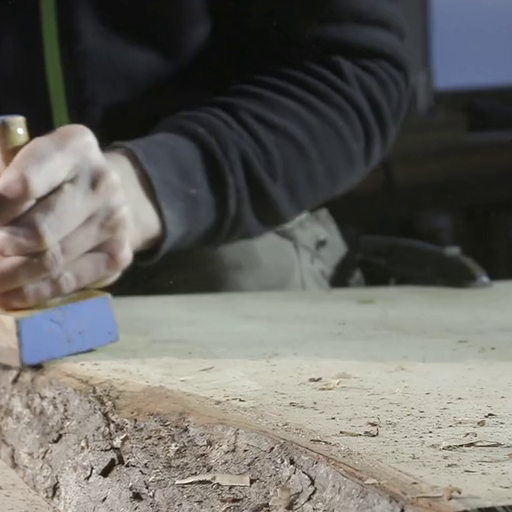

In [26]:
frames[3]

In [27]:
def latents_to_img(latents):
	decoded = pipe.vae.decode(latents.unsqueeze(0) / pipe.vae.config.scaling_factor)[0].squeeze()
	return TF.to_pil_image((decoded / 2 + 0.5).clamp(0, 1))

In [28]:
def frame_to_tensor(image):
	return TF.pil_to_tensor(image).to(dt).cuda() / 256

In [29]:
def double_blocks(blocks): return [torch.cat([torch.zeros_like(b), (b)]) for b in blocks]

In [31]:
preprocess = HEDdetector.from_pretrained('lllyasviel/Annotators')
preprocessed_frames = [TF.pil_to_tensor(preprocess(f).resize(frame_shape)).to(dt) / 256 for f in tqdm(frames)]

100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


In [32]:
class SaveAttention(nn.Module):
	def __init__(self, base, index, **kwargs):
		super().__init__()
		self.base_attn = base
		self.history = []

	def forward(self, hidden_states, encoder_hidden_states=None, attention_mask=None, **cross_attention_kwargs):
		out = self.base_attn.forward(hidden_states, encoder_hidden_states, attention_mask, **cross_attention_kwargs)
		self.history = out.detach()
		# mat = torch.chunk(unpost, 2)[1]
		# self.history = mat.detach()

		return out
	
	def __getattr__(self, name):
		try:
			return super().__getattr__(name)
		except:
			return self.base_attn.__getattribute__(name)

In [14]:
temp = None

In [15]:
class CorrespondingAttention(nn.Module):
	def __init__(self, base, index, **kwargs):
		super().__init__()
		self.base_attn = base
		self.index = index
		self.nearest_neighbor_locations_in_adjacent_keyframes = kwargs['nearest_neighbor_locations_in_adjacent_keyframes'] # layer batch { }
		self.active_frames = kwargs['active_frames'] # batch
		self.keyframe_attns = kwargs['keyframe_attns'] # layer batch hw c
		self.tb_true_to_batch_index = kwargs['tb_true_to_batch_index'] # batch
		self.history = None
	
	def forward(self, hidden_states, encoder_hidden_states=None, attention_mask=None, **cross_attention_kwargs):
		# global temp
		# temp = (self.index, self.nearest_neighbor_locations_in_adjacent_keyframes, self.active_frames, self.keyframe_attns, self.tb_true_to_batch_index)

		my_layer_corr = self.nearest_neighbor_locations_in_adjacent_keyframes[self.index]
		my_layer_keyframe_attns = self.keyframe_attns[self.index] # batch hw c

		batch_before_key_frame_indexes = torch.tensor([self.tb_true_to_batch_index[c['before_frame']] for c in my_layer_corr])
		batch_after_key_frame_indexes = torch.tensor([self.tb_true_to_batch_index[c['after_frame']] for c in my_layer_corr])

		before_keyframe_attns = my_layer_keyframe_attns[batch_before_key_frame_indexes]
		after_keyframe_attns = my_layer_keyframe_attns[batch_after_key_frame_indexes]

		before_shuffled = torch.stack([b[c['before']] for b, c in zip(before_keyframe_attns, my_layer_corr)])
		after_shuffled = torch.stack([a[c['after']] for a, c in zip(after_keyframe_attns, my_layer_corr)])

		w = torch.tensor([(c['center_frame'] - c['before_frame']) / (c['after_frame'] - c['before_frame']) for c in my_layer_corr]).cuda().to(dt)

		out = torch.einsum('ijk,i->ijk', [before_shuffled, 1-w]) + torch.einsum('ijk,i->ijk', [after_shuffled, w])

		self.history = out.detach()
		
		if (out.shape != original.shape):
			raise Exception(f'accidentally modified shape :/ {out.shape}, {original.shape}')

		return out

	def __getattr__(self, name):
		try:
			return super().__getattr__(name)
		except AttributeError:
			return self.base_attn.__getattribute__(name)

In [33]:
class ExtendedAttention(nn.Module):
	def __init__(self, base, index):
		super().__init__()
		self.index = index
		self.base_attn = base
		self.history = None

	def forward(self, hidden_states, encoder_hidden_states=None, attention_mask=None, **cross_attention_kwargs):
		# we batch by polarity (positive / negative prompt), so positive and negative prompts don't cross-attend.

		b = hidden_states.shape[0] // 2
		hidden_states = rearrange(hidden_states, "(p b) hw c -> p (b hw) c", p=2)
		if (encoder_hidden_states is not None):
			encoder_hidden_states = einops.reduce(encoder_hidden_states, "(p b) t c -> p t c", 'mean', p=2)
		out = self.base_attn.forward(hidden_states, encoder_hidden_states, attention_mask, **cross_attention_kwargs)
		out = rearrange(out, "p (b hw) c -> (p b) hw c", b=b, p=2)

		self.history = out.detach() # out.chunk(2)[1].detach()
		return out

	def __getattr__(self, name):
		try:
			# we need this to search _modules, where torch moves otherwise-normal properties.
			# normally you can just do super().__getattr__(name) but that doesn't work here.
			# since .base_attn isn't in the __dict__, and will fallthrough to __getattr__.
			return super().__getattr__(name)
		except AttributeError:
			return self.base_attn.__getattribute__(name)

In [34]:
class NormalAttention(nn.Module):
	def __init__(self, base, index, **kwargs):
		super().__init__()
		self.base_attn = base
		self.history = None

	def forward(self, hidden_states, encoder_hidden_states=None, attention_mask=None, **cross_attention_kwargs):
		out = self.base_attn.forward(hidden_states, encoder_hidden_states, attention_mask, **cross_attention_kwargs) 
		self.history = out.detach()
		return out

	def __getattr__(self, name):
		try:
			return super().__getattr__(name)
		except AttributeError:
			return self.base_attn.__getattribute__(name)

In [20]:
replace_attention(pipe.unet, ExtendedAttention)

In [22]:
collect_attention(pipe.unet, lambda x: x.base_attn.__dict__)

[{'training': False,
  '_parameters': OrderedDict(),
  '_buffers': OrderedDict(),
  '_non_persistent_buffers_set': set(),
  '_backward_pre_hooks': OrderedDict(),
  '_backward_hooks': OrderedDict(),
  '_is_full_backward_hook': None,
  '_forward_hooks': OrderedDict(),
  '_forward_hooks_with_kwargs': OrderedDict(),
  '_forward_pre_hooks': OrderedDict(),
  '_forward_pre_hooks_with_kwargs': OrderedDict(),
  '_state_dict_hooks': OrderedDict(),
  '_state_dict_pre_hooks': OrderedDict(),
  '_load_state_dict_pre_hooks': OrderedDict(),
  '_load_state_dict_post_hooks': OrderedDict(),
  '_modules': OrderedDict([('to_q',
                Linear(in_features=320, out_features=320, bias=False)),
               ('to_k', Linear(in_features=320, out_features=320, bias=False)),
               ('to_v', Linear(in_features=320, out_features=320, bias=False)),
               ('to_out',
                ModuleList(
                  (0): Linear(in_features=320, out_features=320, bias=True)
                  (1): 

In [23]:
pipe.unet.down_blocks[0].attentions[0].transformer_blocks[0].attn1.heads #base_attn.__getattr__("heads") #__dict__

8

In [24]:
# og_frames_batch_latents = torch.randn_like(og_frames_batch_latents) * ddim_fwd.init_noise_sigma

In [25]:
inverted = []
uninverted = []

In [26]:
def invert_ddim(target_timestep, indices):
    og_frames_batch = torch.stack([frame_to_tensor(frames[i]) * 2 - 1 for i in indices]).cuda() # should do *2 -1 probably? TODO
    og_prompt_embeds = pipe._encode_prompt(prompt, 'cuda', do_classifier_free_guidance=True, negative_prompt="ugly", num_images_per_prompt=len(indices))

    og_frames_batch_latents = pipe.vae.encode(og_frames_batch.to(dt).cuda()).latent_dist.sample() * pipe.vae.config.scaling_factor
    guidance = torch.stack([preprocessed_frames[i] for i in indices]).cuda()

    for t in tqdm([t for t in ddim_inv.timesteps if t <= target_timestep]):
        # only do inference on the positive side of CFG, since we have guess mode = True
        inp = einops.repeat(og_frames_batch_latents, "b c h w -> (2 b) c h w")

        down_block_res_samples, mid_block_res_samples = controlnet( inp[len(indices) : 2 * len(indices)], t, encoder_hidden_states=og_prompt_embeds[len(indices) : 2 * len(indices)], controlnet_cond=guidance, conditioning_scale=1.0, return_dict=False, guess_mode=True)

        noise_pred = pipe.unet(inp, t, og_prompt_embeds, down_block_additional_residuals=double_blocks(down_block_res_samples), mid_block_additional_residual=double_blocks([mid_block_res_samples])[0],)[0]
        neg_noise, pos_noise = torch.chunk(noise_pred, 2)
        cfg_noise = neg_noise + 1 * (pos_noise - neg_noise)
        og_frames_batch_latents = ddim_inv.step(cfg_noise, t, og_frames_batch_latents).prev_sample
    
    return og_frames_batch_latents[len(indices):2*len(indices)]

In [27]:
def get_maps_at_time_t(target_timestep, indices):
	replace_attention(pipe.unet, SaveAttention)
	latents = invert_ddim(target_timestep, indices)
	return collect_attention(pipe.unet, lambda x: x.history)

In [28]:
total_layers = 32

In [29]:
def batched_get_maps_at_time_t(target_timestep, indices):
	bs = 10
	batched_indices = [indices[i:i+bs] for i in range(0, len(indices), bs)]
	batched_res = [get_maps_at_time_t(target_timestep, bi) for bi in batched_indices]

	return [torch.cat([b[l] for b in batched_res]).cpu() for l in range(total_layers)]

In [30]:
latents_to_img(invert_ddim(1000, [1, 3, 5])[0])

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:03<00:00,  6.55it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 latents_to_img(invert_ddim(1000, [1, 3, 5])[0])                                              │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: index 0 is out of bounds for dimension 0 with size 0

In [31]:
maps[0].shape

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 maps[0].shape                                                                                │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'maps' is not defined

In [32]:
# bat = batched_get_maps_at_time_t(500, [1, 3, 5, 7, 9])

In [33]:
def get_nearest_neighbor_locations_in_adjacent_keyframes(target_timestep, key_indices):
	out = []
	all_frames = range(len(frames))

	maps = batched_get_maps_at_time_t(target_timestep, all_frames) # [layer][frame][hw][c]

	# eps = 1e-5
	eps = 0
	# eps = torch.finfo(torch.float).eps

	# for layer in (19,):
	for layer in range(len(maps)):
		this_attn_layer = []
		for f in all_frames:

			# print('layer', layer)

			before_i = max([0] + [i for i in key_indices if i < f])
			after_i = min([i for i in key_indices if i > f] + [max(all_frames)])


			before = maps[layer][before_i].cuda().double()
			before = before / (torch.linalg.vector_norm(before, dim=-1, keepdim=True) + eps)
			# before = before.bfloat16()

			after = maps[layer][after_i].cuda().double()
			after = after / (torch.linalg.vector_norm(after, dim=-1, keepdim=True) + eps)
			# after = after.bfloat16()

			current = maps[layer][f].cuda().double()
			current = current / (torch.linalg.norm(current, dim=-1, keepdim=True) + eps)
			# current = current.bfloat16()

			before_nearest_neighbor_locations_in_adjacent_keyframes = before.cuda() @ einops.rearrange(current, "hw c -> c hw")
			before_argmax = torch.argmax(before_nearest_neighbor_locations_in_adjacent_keyframes, dim=0).cpu()
			after_nearest_neighbor_locations_in_adjacent_keyframes = after.cuda() @ einops.rearrange(current, "hw c -> c hw")
			after_argmax = torch.argmax(after_nearest_neighbor_locations_in_adjacent_keyframes, dim=0).cpu()

			this_attn_layer.append({"center_frame": f, "before_frame": before_i, "after_frame": after_i, "before": before_argmax.cpu(), "after": after_argmax.cpu()})

		out.append(this_attn_layer)

	def is_arange(ten):
		return torch.all(ten == torch.arange(0, ten.shape[0]))

	bad = torch.where(torch.tensor([is_arange(corr_layer[0]['before']) for corr_layer in out]) == False)[0] 
	if len(bad) > 0:
		print('bad', bad)

	return out

In [37]:
all_nearest_neighbor_locations_in_adjacent_keyframes = get_nearest_neighbor_locations_in_adjacent_keyframes(300, [0, 2, 9])

100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


In [38]:
len(all_nearest_neighbor_locations_in_adjacent_keyframes)

32

In [39]:
all_nearest_neighbor_locations_in_adjacent_keyframes[0][1]

{'center_frame': 1,
 'before_frame': 0,
 'after_frame': 2,
 'before': tensor([   0,   17,    1,  ..., 6139, 6140, 6143]),
 'after': tensor([1920,    3,    4,  ..., 6105, 6097, 6143])}

In [40]:
all_nearest_neighbor_locations_in_adjacent_keyframes[0][4]

{'center_frame': 4,
 'before_frame': 2,
 'after_frame': 9,
 'before': tensor([   3,    4,    5,  ..., 6137, 6107, 6143]),
 'after': tensor([   0,   11,   12,  ..., 6134, 6094, 6143])}

In [41]:
# collect_attention(pipe.unet, lambda x: print(x) if x.index == 19 else None)

In [42]:
all_nearest_neighbor_locations_in_adjacent_keyframes[0][0]['before']

tensor([   0,    1,    2,  ..., 6141, 6142, 6143])

In [43]:
torch.where((all_nearest_neighbor_locations_in_adjacent_keyframes[19][0]['before'] == torch.arange(0, len(all_nearest_neighbor_locations_in_adjacent_keyframes[19][0]['before']))) == False)[0]

tensor([], dtype=torch.int64)

In [44]:
Image.fromarray(image_data)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 Image.fromarray(image_data)                                                                  │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'image_data' is not defined

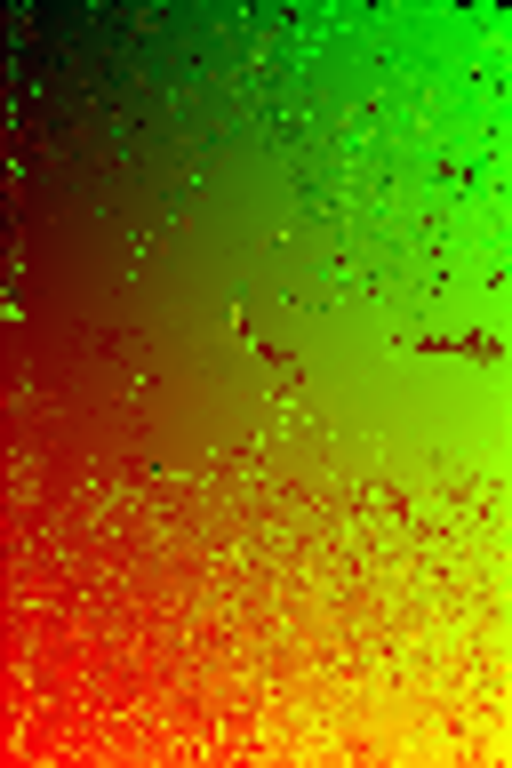

: 

In [82]:
view_layer = 26
view_frame = 1
items = len(all_nearest_neighbor_locations_in_adjacent_keyframes[view_layer][view_frame]['before'])
base_size = round((items // 6) ** 0.5)

bh = base_size * 3
bw = base_size * 2

image_data_1 = (torch.einsum('i,k->ik', torch.arange(bh), torch.ones(bw)).numpy() / bh * 256).astype('uint8')
image_data_2 = (torch.einsum('i,k->ik', torch.ones(bh), torch.arange(bw)).numpy() / bw * 256).astype('uint8')
image_data_3 = (torch.einsum('i,k->ik', torch.ones(bh), torch.ones(bw)).numpy() / bw * 256).astype('uint8')
image_data = np.stack([image_data_1, image_data_2, image_data_3]).transpose(1, 2, 0)

Image.fromarray((image_data.reshape(bw * bh, 3)[all_nearest_neighbor_locations_in_adjacent_keyframes[view_layer][view_frame]['before']]).reshape(bh, bw, 3)).resize((512, 768))

In [46]:
[(c['before_frame'], c['center_frame'], c['after_frame']) for c in all_nearest_neighbor_locations_in_adjacent_keyframes[2]]

[(0, 0, 2),
 (0, 1, 2),
 (0, 2, 9),
 (2, 3, 9),
 (2, 4, 9),
 (2, 5, 9),
 (2, 6, 9),
 (2, 7, 9),
 (2, 8, 9),
 (2, 9, 9)]

In [47]:
timesteps = pipe.scheduler.timesteps

In [48]:
batch_size = 4

In [49]:
def info(name, t): return #print(f'{name}: shape {t.shape} mean {t.mean().item()} std {t.std().item()} min {t.min().item()} max {t.max().item()}')

In [50]:
flowsave, extendedsave = None, None

In [51]:
fs_ddim = DDIMScheduler.from_config(pipe.scheduler.config)
def flow_stage(all_latents, nearest_neighbor_locations_in_adjacent_keyframes, t, keyframe_attns, tb_true_to_batch_index, blacklist_indexes):
    flow_target_batch_size = 10
    for batch_indexes in torch.split(torch.arange(total_frames), flow_target_batch_size):
        print('before', batch_indexes)
        batch_indexes = torch.stack([x for x in batch_indexes if x not in blacklist_indexes])
        print('after', batch_indexes)
        prompt_embeds = pipe._encode_prompt(
            prompt,
            "cuda",
            # do_classifier_free_guidance=True,
            do_classifier_free_guidance=False,
            # negative_prompt="ugly",
            num_images_per_prompt=len(batch_indexes),
        )

        controlnet_guidance = torch.stack([preprocessed_frames[i] for i in batch_indexes]).cuda()

        batch_nearest_neighbor_locations_in_adjacent_keyframes = [[l[bi] for bi in batch_indexes] for l in nearest_neighbor_locations_in_adjacent_keyframes]

        replace_attention(
            pipe.unet,
            CorrespondingAttention,
            # NormalAttention,
            nearest_neighbor_locations_in_adjacent_keyframes=batch_nearest_neighbor_locations_in_adjacent_keyframes,
            active_frames=batch_indexes,
            keyframe_attns=keyframe_attns,
            tb_true_to_batch_index=tb_true_to_batch_index,
        )

        latents = all_latents[batch_indexes]
        latent_model_inputs = latents
        # latent_model_inputs = einops.repeat(latents, "b c h w -> (2 b) c h w")
        latent_model_inputs = fs_ddim.scale_model_input(
            latent_model_inputs, t
        )  # why this? not a no-op for Euler Ancestral

        down_block_res_samples, mid_block_res_samples = controlnet(
            # latent_model_inputs[len(batch_indexes) : 2 * len(batch_indexes)],
            latent_model_inputs,
            t,
            # encoder_hidden_states=prompt_embeds[ len(batch_indexes) : 2 * len(batch_indexes) ],
            encoder_hidden_states=prompt_embeds,
            controlnet_cond=controlnet_guidance,
            conditioning_scale=1.0,
            return_dict=False,
            guess_mode=True,
        )
        noise_pred = pipe.unet(
            latent_model_inputs,
            t,
            encoder_hidden_states=prompt_embeds,
            # down_block_additional_residuals=double_blocks(down_block_res_samples),
            # mid_block_additional_residual=double_blocks([mid_block_res_samples])[0],
            down_block_additional_residuals=down_block_res_samples,
            mid_block_additional_residual=[mid_block_res_samples][0],
            return_dict=False,
        )[0]

        # global flowsave
        # flowsave = (prompt_embeds[0], controlnet_guidance[0], noise_pred[0], latents[0], down_block_res_samples, mid_block_res_samples)
        # print('np', noise_pred[0])

        # negative_noise, guided_noise = (
        #     noise_pred[0 : len(batch_indexes)],
        #     noise_pred[len(batch_indexes) : len(batch_indexes) * 2],
        # )
        # cfg_noise = negative_noise + 3 * (guided_noise - negative_noise)
        cfg_noise = noise_pred

        latents = fs_ddim.step(cfg_noise, t, latents, return_dict=False)[0]
        all_latents[batch_indexes] = latents

In [52]:
fs_ddim = DDIMScheduler.from_config(pipe.scheduler.config)
fs_ddim.set_timesteps(ts)
es_ddim = DDIMScheduler.from_config(pipe.scheduler.config)
es_ddim.set_timesteps(ts)

original_noise = (
    torch.randn(
        total_frames,
        pipe.vae.config.latent_channels,
        frame_shape[1] // pipe.vae_scale_factor,
        frame_shape[0] // pipe.vae_scale_factor,
    )
    .to(dt)
    .cuda()
)
original_noise.shape
all_latents = original_noise * pipe.scheduler.init_noise_sigma

# print('random', all_latents.shape, all_latents.mean(), all_latents.std())

# all_latents = invert_ddim(10001, np.arange(total_frames))
# print('seeded', all_latents.shape, all_latents.mean(), all_latents.std())
# original_image_latents = pipe.vae.encode(init_image.to(dt).cuda()).latent_dist.sample() * pipe.vae.config.scaling_factor
# latents = pipe.scheduler.add_noise(original_image_latents, original_noise, torch.tensor([timesteps[0]]).cuda()) # does this actually work? or does it somehow fuck around with the distribution

prompt_embeds = pipe._encode_prompt(
    prompt,
    "cuda",
    do_classifier_free_guidance=True,
    negative_prompt="ugly",
    num_images_per_prompt=batch_size,
)

with torch.no_grad():
    pipe.vae.eval(), pipe.unet.eval()
    controlnet.eval()
    for i, t in tqdm(enumerate(timesteps)):
        replace_attention(pipe.unet, ExtendedAttention)
        # random_frame_indexes = sorted([0] + [len(frames) - 1] + random.sample(range(1, len(frames)-1), batch_size - 2))
        random_frame_indexes = [0, 3, 6, 9]
        print("random frames selected", random_frame_indexes)
        random_controlnet_guidance = torch.stack([preprocessed_frames[i] for i in random_frame_indexes]).cuda()
        random_latents = all_latents[random_frame_indexes]

        before_random_latents = all_latents[0].clone()

        latent_model_inputs = einops.repeat(random_latents, "b c h w -> (2 b) c h w")
        latent_model_inputs = pipe.scheduler.scale_model_input(
            latent_model_inputs, t
        )  # why this? not a no-op for Euler Ancestral

        # only do inference on the positive side of CFG, since we have guess mode = True
        down_block_res_samples, mid_block_res_samples = controlnet(
            latent_model_inputs[batch_size : 2 * batch_size],
            t,
            encoder_hidden_states=prompt_embeds[batch_size : 2 * batch_size],
            controlnet_cond=random_controlnet_guidance,
            conditioning_scale=1.0,
            return_dict=False,
            guess_mode=True,
        )

        noise_pred = pipe.unet(
            latent_model_inputs,
            t,
            encoder_hidden_states=prompt_embeds,
            down_block_additional_residuals=double_blocks(down_block_res_samples),
            mid_block_additional_residual=double_blocks([mid_block_res_samples])[0],
            return_dict=False,
        )[0]

        negative_noise, guided_noise = (
            noise_pred[0:batch_size],
            noise_pred[batch_size : batch_size * 2],
        )

        # print('gn', guided_noise[0])
        cfg_noise = negative_noise + 1 * (guided_noise - negative_noise)

        extended_updated_latents = es_ddim.step(cfg_noise, t, random_latents, return_dict=False)[0]
        # random_latents = pipe.scheduler.step(cfg_noise, t, random_latents, return_dict=False)[0]
        # all_latents[random_frame_indexes] = random_latents # TODO: don't update on the first pass.

        # outs.append(latents_to_img(random_latents[0]))

        keyframe_attns = collect_attention(pipe.unet, lambda x: x.history)

        # print(keyframe_attns[0], keyframe_attns[0].shape, len(keyframe_attns))

        tb_true_to_batch_index = {ri: i for i, ri in enumerate(random_frame_indexes)}

        nearest_neighbor_locations_in_adjacent_keyframes = get_nearest_neighbor_locations_in_adjacent_keyframes(t, random_frame_indexes)
        # flow_stage(all_latents, nearest_neighbor_locations_in_adjacent_keyframes, t, keyframe_attns, tb_true_to_batch_index, random_frame_indexes)
        # before_latents = all_latents[0].clone()
        after_random_latents = all_latents[0].clone()
        # print('before rl, after rt', torch.allclose(after_random_latents, before_random_latents))

        # so the inputs are the same, and the attentions are the same, but somehow the outputs are different (?).
        # are the outputs from the first step actually different?
        # if so, what else can be different here?
        # global extendedsave
        # extendedsave = (prompt_embeds[batch_size], random_controlnet_guidance[0], noise_pred[0], random_latents[0], down_block_res_samples, mid_block_res_samples)

        flow_stage(all_latents, nearest_neighbor_locations_in_adjacent_keyframes, t, keyframe_attns, tb_true_to_batch_index, [])
        # print('are the outputs the same?', torch.allclose(all_latents[0], extended_updated_latents[0]))
        applied_attns = collect_attention(pipe.unet, lambda x: x.history)

        # print([torch.allclose(applied_attns[i][0], keyframe_attns[i][0]) for i in range(len(applied_attns))])
        if not torch.allclose(applied_attns[0][0], keyframe_attns[0][0]):
            print('flow stage should be a no-op for frame 0, but frame zero latents changed.')

0it [00:00, ?it/s]

random frames selected [0, 3, 6, 9]


100%|██████████| 20/20 [00:06<00:00,  2.92it/s]
1it [00:12, 12.53s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 19/19 [00:06<00:00,  2.93it/s]
2it [00:24, 12.30s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 18/18 [00:06<00:00,  2.94it/s]
3it [00:36, 12.07s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]
4it [00:47, 11.82s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 16/16 [00:05<00:00,  2.95it/s]
5it [00:59, 11.56s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]
6it [01:09, 11.28s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 14/14 [00:04<00:00,  2.96it/s]
7it [01:20, 10.99s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]
8it [01:30, 10.69s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 12/12 [00:04<00:00,  2.99it/s]
9it [01:39, 10.38s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 11/11 [00:03<00:00,  3.00it/s]
10it [01:49, 10.06s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]
11it [01:58,  9.73s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 9/9 [00:02<00:00,  3.04it/s]
12it [02:06,  9.40s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 8/8 [00:02<00:00,  3.06it/s]
13it [02:15,  9.06s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 7/7 [00:02<00:00,  3.10it/s]
14it [02:23,  8.72s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 6/6 [00:01<00:00,  3.15it/s]
15it [02:30,  8.37s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 5/5 [00:01<00:00,  3.22it/s]
16it [02:37,  8.02s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]
17it [02:44,  7.68s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]
18it [02:51,  7.33s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 2/2 [00:00<00:00,  4.05it/s]
19it [02:57,  6.98s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
random frames selected [0, 3, 6, 9]


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]
20it [03:03,  9.16s/it]

before tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [53]:
# 12 x { 4 x 320 x 96 x 64 } 

In [54]:
down_block_res_samples[0][0].sum()

tensor(57.5000, device='cuda:0', dtype=torch.bfloat16)

In [55]:
flowsave[0] is extendedsave[0]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 flowsave[0] is extendedsave[0]                                                               │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'NoneType' object is not subscriptable

In [56]:
torch.allclose(flowsave[4][1][0], extendedsave[4][1][0])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 torch.allclose(flowsave[4][1][0], extendedsave[4][1][0])                                     │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'NoneType' object is not subscriptable

In [57]:
torch.max(torch.abs(flowsave[4][0][0] - extendedsave[4][0][0]))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 torch.max(torch.abs(flowsave[4][0][0] - extendedsave[4][0][0]))                              │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'NoneType' object is not subscriptable

In [58]:
f = 0.000000001

In [59]:
guided_noise[0].std()

tensor(0.2617, device='cuda:0', dtype=torch.bfloat16)

In [60]:
torch.std(guided_noise[0] - np[0])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 torch.std(guided_noise[0] - np[0])                                                           │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'module' object is not subscriptable

In [61]:
torch.max(torch.abs(all_latents[0] - extended_updated_latents[0]))

tensor(0.0078, device='cuda:0', dtype=torch.bfloat16)

In [62]:
[torch.allclose(applied_attns[i][0], keyframe_attns[i][0]) for i in range(len(applied_attns))]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [63]:
torch.max(after_latents - before_latents)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 torch.max(after_latents - before_latents)                                                    │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'after_latents' is not defined

In [64]:
# frames[8]

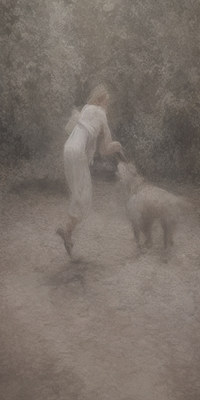

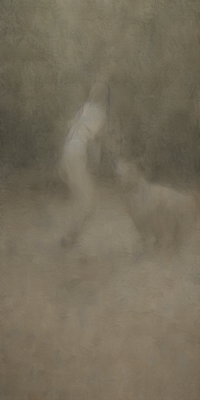

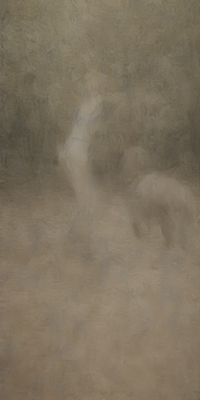

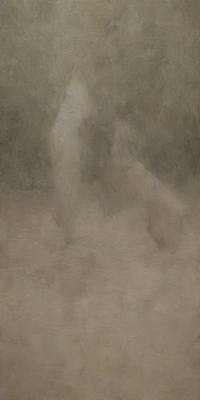

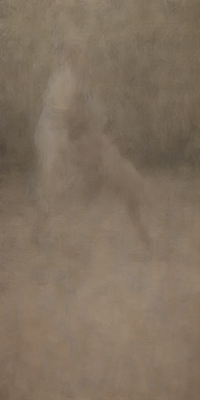

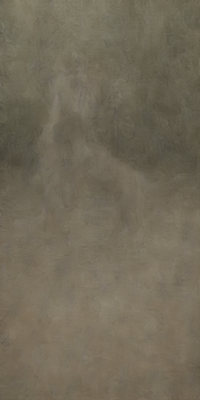

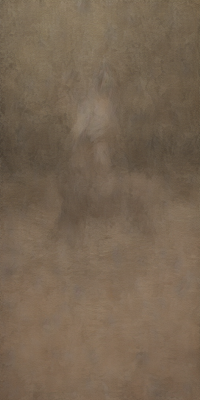

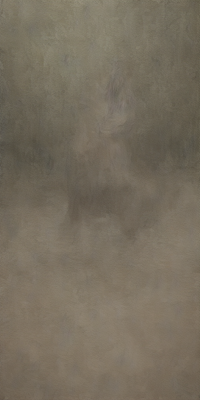

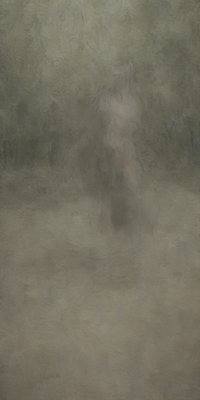

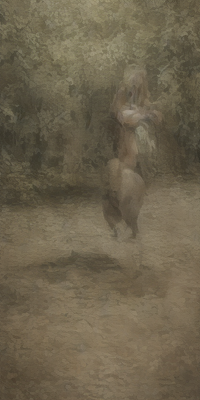

In [67]:
display(*[latents_to_img(i).resize((200, 400), Image.LANCZOS) for i in all_latents])

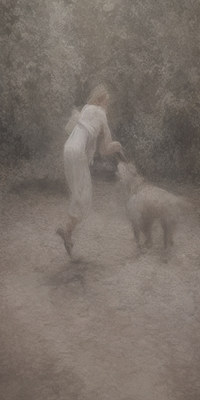

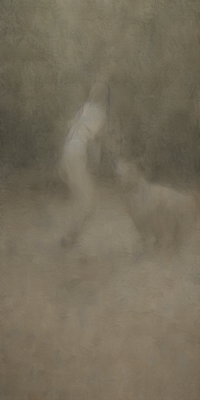

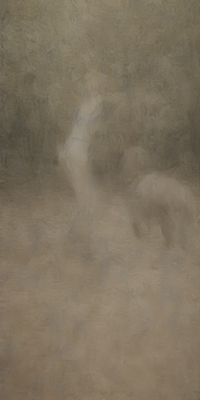

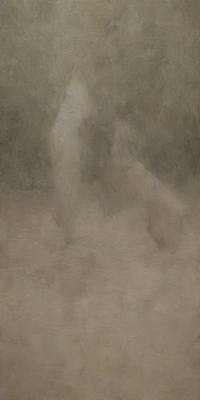

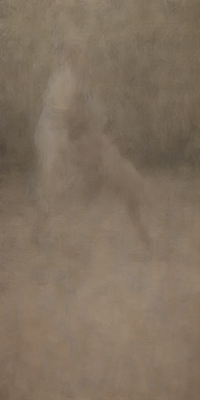

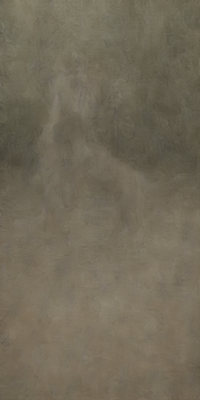

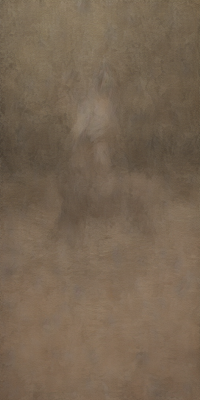

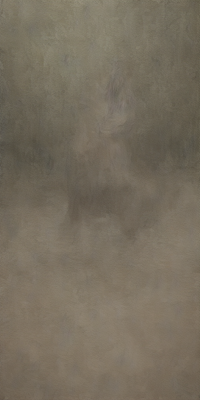

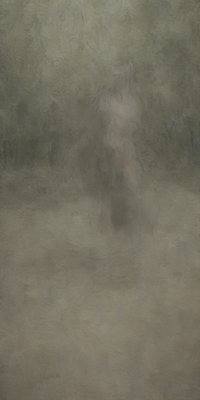

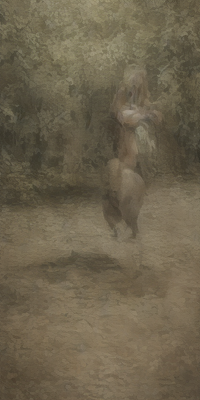

In [66]:
display(*[latents_to_img(i).resize((200, 400), Image.LANCZOS) for i in all_latents])